# **Connect to google drive**

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


# **Importing necessary modules**

In [86]:
from pathlib import Path
import IPython.display as display
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import numpy as np
import torchaudio.transforms as T
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F

#**Preprocessing**

In [4]:
data_path = Path('/content/drive/MyDrive/genres')
data_path

PosixPath('/content/drive/MyDrive/genres')

In [8]:
audio_list = list(data_path.glob('*/*.au'))
len(audio_list),audio_list[:5]

(1000,
 [PosixPath('/content/drive/MyDrive/genres/hiphop/hiphop.00000.au'),
  PosixPath('/content/drive/MyDrive/genres/hiphop/hiphop.00001.au'),
  PosixPath('/content/drive/MyDrive/genres/hiphop/hiphop.00004.au'),
  PosixPath('/content/drive/MyDrive/genres/hiphop/hiphop.00010.au'),
  PosixPath('/content/drive/MyDrive/genres/hiphop/hiphop.00009.au')])

In [47]:
sample = random.choice(audio_list)
wave_form,sample_rate = torchaudio.load(sample)
len(wave_form.squeeze(0))

661794

22050


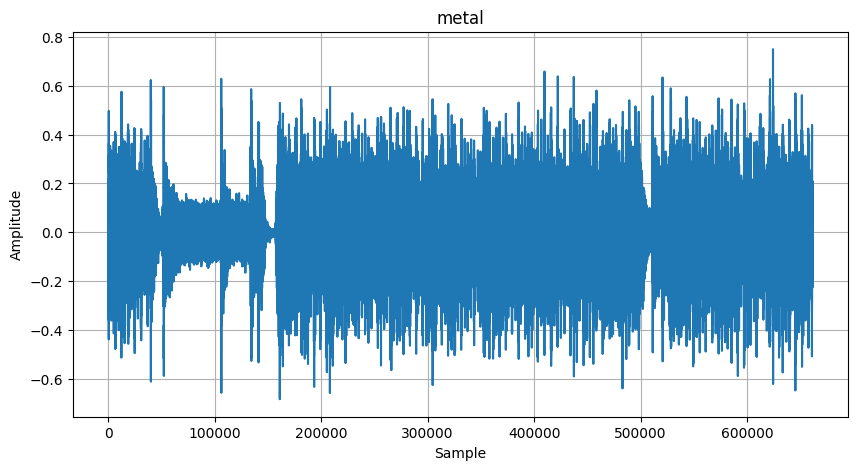

In [40]:
sample = random.choice(audio_list)
wave_form,sample_rate = torchaudio.load(sample)
print(sample_rate)
plt.figure(figsize=(10,5))
plt.plot(wave_form.t().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(sample.parent.stem)
plt.grid()
plt.show()

In [48]:
class pipeline(nn.Module):
    def __init__(self,input_freq=44100,resample_freq=20000):
        super().__init__()
        self.resample = T.Resample(orig_freq=input_freq,new_freq=resample_freq)
    def forward(self,x):
        resampled = self.resample(x)
        return resampled

In [49]:
p = pipeline()

In [85]:
sample = random.choice(audio_list)
waveform,_ = torchaudio.load(sample)
transformed = p(waveform)
print(len(transformed.squeeze(0)))



300134


1


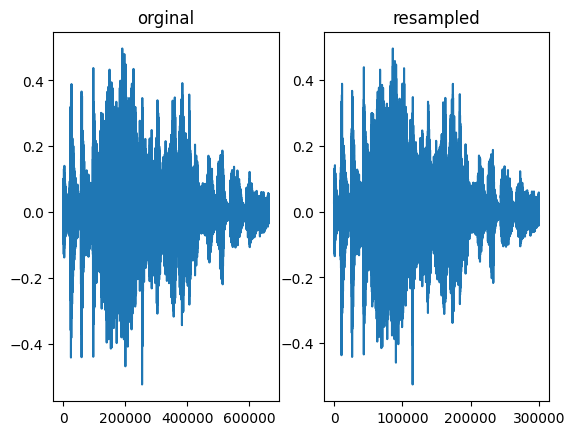

In [56]:
sample = random.choice(audio_list)
waveform,_ = torchaudio.load(sample)
fig,ax = plt.subplots(1,2)
ax[0].plot(waveform.t().numpy())
ax[0].set_title('orginal')
transformed = p(waveform)
ax[1].plot(transformed.t().numpy())
ax[1].set_title('resampled')


In [81]:
random.shuffle(audio_list)
train = audio_list[:800]
test = audio_list[800:]

In [84]:
labels = list(set(list(x.parent.stem for x in audio_list)))
label_encoder = {v:k for k,v in enumerate(labels)}
label_encoder

{'pop': 0,
 'country': 1,
 'metal': 2,
 'disco': 3,
 'reggae': 4,
 'classical': 5,
 'jazz': 6,
 'hiphop': 7,
 'blues': 8,
 'rock': 9}

In [97]:
class AUDIODATASET(Dataset):
    def __init__(self,input,label=label_encoder,pipe=p):
        super().__init__()
        self.input = input
        self.label = label
        self.pipe = p
    def __len__(self):
        return len(self.input)
    def __getitem__(self,idx):
        sample = self.input[idx]
        waveform,_ = torchaudio.load(sample)
        transformed = self.pipe(waveform)
        padded = self.pad(transformed)
        music_type = sample.parent.stem
        return padded.squeeze(0),self.label[music_type]

    def pad(self,wave):
        target_length = 300000
        padded_waveform = F.pad(wave, (0, target_length - wave.size(1)), value=-1)
        return padded_waveform




In [101]:
train_data = AUDIODATASET(
    input=train
)
# train_data

# sample,label = random.choice(train_data)
# sample,label
# len(sample),label
test_data = AUDIODATASET(
    input=test
)

In [103]:
bs = 4
train_loader = DataLoader(
            train_data,
            batch_size=bs,
            shuffle=True

)

test_loader = DataLoader(
    test_data,
    batch_size=bs,
    shuffle=False
)

sample,label = next(iter(train_loader))
sample,label

(tensor([[ 0.0379,  0.0855,  0.1207,  ...,  0.3904,  0.3078,  0.1451],
         [ 0.0348,  0.0687, -0.1047,  ...,  0.0482,  0.0288,  0.1200],
         [ 0.0661,  0.1121,  0.1878,  ..., -0.1542,  0.1850,  0.1904],
         [-0.4297, -0.7957, -0.6635,  ...,  0.3645,  0.0314,  0.3081]]),
 tensor([3, 2, 1, 2]))